In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [156]:
class Environment():
    def __init__(self,):
        # Environment cards
        self.cards = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "J", "Q", "K", "A"]
        self.probs = [1.0/len(self.cards) for i in range(0, len(self.cards))]
        
        # Reset the environment to start the environment
        self.reset_environment()
    
    # Used to make an action in the current state. Return the reward for the action.
    def take_action(self, action):
        if action == "HIT":
            self.player.append(np.random.choice(self.cards, size=1, replace=True, p=self.probs)[0])
        elif action == "STAY":
            self.user_end = True
        else:
            raise RuntimeError(f"Unknown action {action}")
        
        # Reward is 0 for every game.
        return 0
        
    # Used to get all the actions
    def get_actions(self,):
        return self.cards
    
    # Used to get the sum of a list of items
    def get_sum(self, items):
        s = 0
        for i in items:
            if i in ["1", "2", "3", "4", "5", "6", "7", "8", "9"]:
                s += int(i)
            elif i in ["J", "Q", "K"]:
                s += 10
            elif i == "A":
                s += 11 if self.useable_ace else 1
            else:
                raise RuntimeError(f"Unknown card: {i}")
        return s
    
    # Used to get the current state
    def get_state(self, ):
        # State is the current user sum, the dealer's showing card, and if the ace is useable or not.
        return self.get_sum(self.player), self.get_sum(self.dealer[:1]), self.useable_ace
    
    # Has the game ended?
    def game_ended(self, ):
        # Game has ended if the player busts or if the player has stopped the game
        if self.user_end or self.get_sum(self.player) > 21:
            return True
        return False
    
    # Used to end an episode and reset the environment, returning the reward
    # at the end of the game.
    def end_episode(self, ):
        # Did the user bust, if so, return -1
        if self.get_sum(self.player) > 21:
            self.reset_environment()
            return -1
        
        # Iterate until the dealer is 17 or over
        while self.get_sum(self.dealer) < 17:
            self.dealer.append(np.random.choice(self.cards, size=1, replace=True, p=self.probs)[0])
            
        # Did the dealer bust, if so, return 1
        if self.get_sum(self.dealer) > 21:
            self.reset_environment()
            return 1
        
        # If the dealer has a higher value, return -1
        if self.get_sum(self.dealer) > self.get_sum(self.player):
            self.reset_environment()
            return -1
        
        # If the player has a higher value, return 1
        elif self.get_sum(self.dealer) < self.get_sum(self.player):
            self.reset_environment()
            return 1
        
        # If not, then it's a tie
        self.reset_environment()
        return 0
    
    # Used to reset the environment and start a new episode
    def reset_environment(self, ):
        # Sample two cards for the dealer, first is observable, second is not
        self.dealer = list(np.random.choice(self.cards, size=2, replace=True, p=self.probs))
        
        # Sample two cards for the player
        self.player = list(np.random.choice(self.cards, size=2, replace=True, p=self.probs))
        
        # Start the ace as not useable (so it's just 1)
        self.useable_ace = False
        
        # Has the user ended the game yet?
        self.user_end = False

In [157]:
# Policy
class Policy():
    def __init__(self, ):
        pass
    
    def __call__(self, state):
        # If the sum is 20 or 21, stay, otherwise hit
        if state[0] >= 20:
            return "STAY"
        return "HIT"

In [158]:
# First-visit MC
class FirstVisitMC():
    def __init__(self, ):
        # Values for all states that have been seen
        self.values = {}
        
        # Returns for each state is 0
        self.returns = {}
      
      
        
    # Generate an episode of data given a policy
    def generate_episode(self, policy, game):
        # Episode consists of states, actions, and rewards (indexed at +1)
        episode = {
            "states": [],
            "actions": [],
            "rewards": [0],
        }
        
        # Iterate until the game has ended
        while not game.game_ended():
            # Get the state of the game
            state = game.get_state()
            episode["states"].append(state)
            
            # Get a new prediction from the policy
            action = policy(state)
            episode["actions"].append(action)
            
            # Update the state, get the reward if any
            reward = game.take_action(action)
            episode["rewards"].append(reward)
            
        # End the episode
        episode_reward = game.end_episode()
            
        # Replace last reward with the episode end reward
        episode["rewards"][-1] = episode_reward
        
        return episode
      
        
    # Used to optimize a policy given MC
    def optimize_policy(self, policy, game, num_iters):
        for iter in range(0, num_iters):
            # Generate an episode of data following the policy, pi
            episode = self.generate_episode(policy, game)
            
            # States already visited
            visited = set()
            
            # Generate the reward for the episode
            G = 0
            for t in range(len(episode["states"])-1, -1, -1):
                state = episode["states"][t]
                action = episode["actions"][t]
                reward = episode["rewards"][t+1]
                
                # Update G to the current timestep
                G = discount * G + reward
                
                # Do not revisit already visited states
                if state not in visited:
                    # Save the return, G, for the current state
                    try:
                        self.returns[state].append(G)
                    except KeyError:
                        self.returns[state] = [G]
                        
                    # Update the value of this state as teh averge return
                    self.values[state] = sum(self.returns[state])/len(self.returns[state])
                
                # Update the visited states
                visited.add(state)

In [159]:
discount = 1.0

In [166]:
# Create environment
env = Environment()

# Create policy
policy = Policy()

# Calculate values by first-visit MC
FVMC = FirstVisitMC()

In [167]:
FVMC.optimize_policy(policy, env, 50_000)

In [168]:
FVMC.values

{(19, 1, False): -0.5991316931982634,
 (9, 1, False): -0.4940652818991098,
 (20, 10, False): 0.5836477987421383,
 (16, 10, False): -0.6109618484685653,
 (18, 10, False): -0.6428945988463556,
 (13, 10, False): -0.5230589608873322,
 (15, 2, False): -0.613747954173486,
 (14, 2, False): -0.49912739965095987,
 (10, 2, False): -0.3080568720379147,
 (21, 1, False): 0.8418024928092043,
 (11, 1, False): -0.13844936708860758,
 (17, 10, False): -0.6465686274509804,
 (18, 9, False): -0.625,
 (8, 9, False): -0.4870967741935484,
 (14, 10, False): -0.5762996087199553,
 (18, 1, False): -0.704225352112676,
 (11, 10, False): -0.08550573514077164,
 (10, 10, False): -0.2227112676056338,
 (14, 4, False): -0.5530035335689046,
 (9, 4, False): -0.5135135135135135,
 (15, 10, False): -0.5895522388059702,
 (12, 10, False): -0.4726027397260274,
 (3, 10, False): -0.49523809523809526,
 (9, 10, False): -0.48123195380173245,
 (21, 4, False): 0.9035916824196597,
 (11, 4, False): -0.221875,
 (21, 2, False): 0.892605633

In [171]:
for r in FVMC.returns:
    if r[0] == 21:
        print(r, FVMC.returns[r])

(21, 1, False) [1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0,

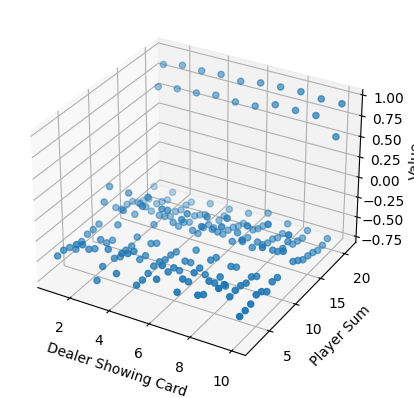

In [170]:
# Plot a 3D plot where the x-axis is the dealer showing card, the y-axis is the player sum, and the z-axis is the value
x = []
y = []
z = []
for state in FVMC.values:
    x.append(state[1])
    y.append(state[0])
    z.append(FVMC.values[state])
    
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z)
ax.set_xlabel("Dealer Showing Card")
ax.set_ylabel("Player Sum")
ax.set_zlabel("Value")
plt.show()